In [74]:
from pathlib import Path
from typing import Optional, List
import os

from einops import rearrange
from timm import create_model
from torch.utils.data import DataLoader, Dataset
import lightning as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2.functional as TF
import torchvision.transforms.v2 as transforms
import tifffile
import timm
import yaml


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import mushroom.data.multiplex as multiplex
import mushroom.utils as utils

In [5]:
# target_channel = 'E-cadherin'
target_channel = 'Pan-Cytokeratin'
scales = [1, 2, 4]

In [78]:
metadata = yaml.safe_load(open('/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/metadata.yaml'))
metadata

{'resolution': 1.0,
 'sections': [{'data': [{'dtype': 'xenium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s0_HT704B1-U1_xenium.h5ad'}],
   'position': 0,
   'sid': 'HT704B1-U1'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s1_HT704B1-U11_multiplex.ome.tiff'}],
   'position': 50,
   'sid': 'HT704B1-U11'},
  {'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s2_HT704B1-U12_he.tif'}],
   'position': 55,
   'sid': 'HT704B1-U12'},
  {'data': [{'dtype': 'cosmx',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s3_HT704B1-U14_cosmx.h5ad'}],
   'position': 65,
   'sid': 'HT704B1-U14'},
  {'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/H

In [6]:
train_multiplex_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s1_HT704B1-U11_multiplex.ome.tiff'
train_he_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s2_HT704B1-U12_he.tif'
val_multiplex_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s38_HT704B1-U85_multiplex.ome.tiff'
val_he_fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s39_HT704B1-U90_he.tif'

In [7]:
multiplex.get_ome_tiff_channels(train_multiplex_fp)

['DAPI',
 'Granzyme B',
 'Keratin 5',
 'PLAT/tPA (D)',
 'CTLA4 (D)',
 'CD31',
 'CD4 (D)',
 'SLC39A6 (D)',
 'TCF-1',
 'BCA1',
 'CD68',
 'CD39',
 'FOXP3',
 'CD163',
 'PD-1',
 'MLPH',
 'CD8',
 'HER2 (D)',
 'GLUT1 (D)',
 'ckit-(D)',
 'Pan-Cytokeratin',
 'HIF1a',
 'Podoplanin (D)',
 'CD20',
 'HLA-DR',
 'CK14 (D)',
 'TFF1 (D)',
 'MGP (D)',
 'Ki67',
 'Vimentin',
 'CD3e',
 'E-cadherin',
 'SMA (D)',
 'cd11b',
 'PR (D)',
 'CD45 (D)',
 'GATA3',
 'COX6C (D)']

In [8]:
train_multiplex = multiplex.extract_ome_tiff(train_multiplex_fp, channels=[target_channel])[target_channel]
val_multiplex = multiplex.extract_ome_tiff(val_multiplex_fp, channels=[target_channel])[target_channel]

train_he = tifffile.imread(train_he_fp)
val_he = tifffile.imread(val_he_fp)

In [9]:
multiplex.get_ome_tiff_channels(train_multiplex_fp)

['DAPI',
 'Granzyme B',
 'Keratin 5',
 'PLAT/tPA (D)',
 'CTLA4 (D)',
 'CD31',
 'CD4 (D)',
 'SLC39A6 (D)',
 'TCF-1',
 'BCA1',
 'CD68',
 'CD39',
 'FOXP3',
 'CD163',
 'PD-1',
 'MLPH',
 'CD8',
 'HER2 (D)',
 'GLUT1 (D)',
 'ckit-(D)',
 'Pan-Cytokeratin',
 'HIF1a',
 'Podoplanin (D)',
 'CD20',
 'HLA-DR',
 'CK14 (D)',
 'TFF1 (D)',
 'MGP (D)',
 'Ki67',
 'Vimentin',
 'CD3e',
 'E-cadherin',
 'SMA (D)',
 'cd11b',
 'PR (D)',
 'CD45 (D)',
 'GATA3',
 'COX6C (D)']

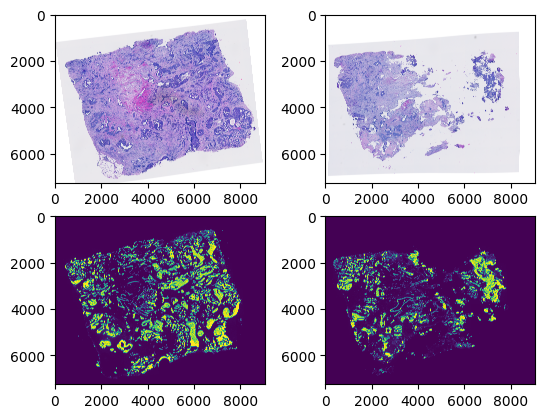

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0, 0].imshow(train_he)
ax[0, 1].imshow(val_he)
ax[1, 0].imshow(train_multiplex)
ax[1, 1].imshow(val_multiplex)

In [11]:
train_he = rearrange(train_he, 'h w c -> c h w').astype(np.float32)
val_he = rearrange(val_he, 'h w c -> c h w').astype(np.float32)

train_multiplex = rearrange(train_multiplex, 'h w -> 1 h w').astype(np.float32)
val_multiplex = rearrange(val_multiplex, 'h w -> 1 h w').astype(np.float32)

In [12]:
means, stds = train_he.mean((-2, -1)), train_he.std((-2, -1))
norm = transforms.Normalize(means, stds)
means, stds

(array([65.38734, 65.38734, 65.38734], dtype=float32),
 array([122.32432, 120.97105, 124.04102], dtype=float32))

In [13]:
train_hes = [utils.rescale(train_he, scale=1 / scale, dim_order='c h w', target_dtype=np.float32)
             for scale in scales]
val_hes = [utils.rescale(val_he, scale=1 / scale, dim_order='c h w', target_dtype=np.float32)
           for scale in scales]

for x in train_hes:
    print(x.shape)

(3, 7250, 9060)
(3, 3625, 4530)
(3, 1812, 2265)


In [14]:
def to_he(x, norm=None):
    if x.shape[0] == 3:
        x = rearrange(x, 'c h w -> h w c')
    
    if norm is not None:
        x *= rearrange(np.asarray(norm.std), 'n -> 1 1 n')
        x += rearrange(np.asarray(norm.mean), 'n -> 1 1 n')
    
    if not isinstance(x, np.ndarray):
        x = x.numpy()

    return x.astype(np.uint8)

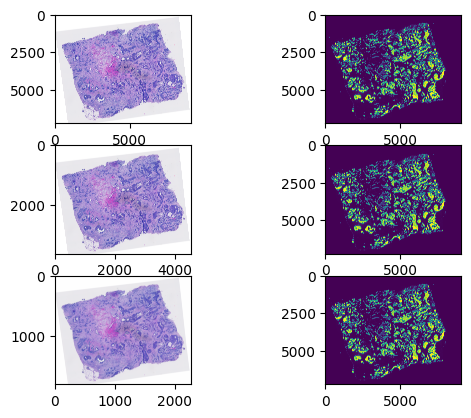

In [15]:
fig, axs = plt.subplots(nrows=len(scales), ncols=2)
for i, he in enumerate(train_hes):
    axs[i, 0].imshow(to_he(he))
    axs[i, 1].imshow(train_multiplex[0])

In [16]:
multiplex_max = train_multiplex.max()
multiplex_max

255.0

In [17]:
train_hes = [torch.tensor(x) for x in train_hes]
val_hes = [torch.tensor(x) for x in val_hes]

train_multiplex = torch.tensor(train_multiplex / multiplex_max)
val_multiplex = torch.tensor(val_multiplex / multiplex_max)

In [41]:
class TrainingTransform(object):
    def __init__(self, norm):
        self.norm = norm

    def __call__(self, he_tiles, y_tile):
        vflip = np.random.rand() > .5
        hflip = np.random.rand() > .5
        
        if hflip:
            he_tiles = [TF.hflip(tile) for tile in he_tiles]
            y_tile = TF.hflip(y_tile)
        
        if vflip:
            he_tiles = [TF.vflip(tile) for tile in he_tiles]
            y_tile = TF.vflip(y_tile)
            
        he_tiles = [self.norm(tile) for tile in he_tiles]

        return he_tiles, y_tile
    
class ValTransform(object):
    def __init__(self, norm):
        self.norm = norm

    def __call__(self, he_tiles, y_tile):
        he_tiles = [self.norm(tile) for tile in he_tiles]
        
        return he_tiles, y_tile
    
class InferenceTransform(object):
    def __init__(self, norm):
        self.norm = norm

    def __call__(self, he_tiles):
        he_tiles = [self.norm(tile) for tile in he_tiles]
        
        return he_tiles

In [42]:
class TrainingDataset(Dataset):
    def __init__(self, hes, y, scales, transform, size=256, n=None):
        assert hes[0].shape[1:] == y.shape[1:]
        assert len(scales) == len(hes)
        
        self.n_zooms = len(hes)
        self.scales = scales
        
        self.hes = hes
        self.y = y
        
        self.h, self.w = hes[0].shape[1:]
        self.size = size
        self.hs = np.arange(self.h - size - 1)
        self.ws = np.arange(self.w - size - 1)
        
        self.zoom_to_coords = []
        for i, scale in enumerate(self.scales):
            hs = [x + self.size // 2 for x in self.hs] # to center
            ws = [x + self.size // 2 for x in self.ws]
            
            hs = [x // scale for x in hs] # scale
            ws = [x // scale for x in ws]
            
            hs = [x - self.size // 2 for x in hs] # to top left corner
            ws = [x - self.size // 2 for x in ws]
            
            self.zoom_to_coords.append([hs, ws])

        self.transform = transform

        self.n = np.iinfo(np.int64).max if n is None else n

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        h_idx, w_idx = np.random.choice(np.arange(len(self.hs))), np.random.choice(np.arange(len(self.ws)))

        he_tiles = []
        y_tile = None
        h_coord, w_coord = None, None
        for i, ((hs, ws), scale, he) in enumerate(zip(self.zoom_to_coords, self.scales, self.hes)):
            h, w = hs[h_idx], ws[w_idx]
            left, top, right, bottom = 0, 0, 0, 0
            if h < 0:
                top = abs(h)
            if w < 0:
                left = abs(w)
            if h + self.size >= he.shape[-2]:
                bottom = h + self.size - he.shape[-2]
            if w + self.size >= he.shape[-1]:
                right = w + self.size - he.shape[-1]
            
            r, c = max(h, 0), max(w, 0)
            he_tiles.append(TF.pad(
                he[:, r:r + self.size - top, c:c + self.size - left],
                padding=(left, top, right, bottom), 
                padding_mode='reflect'
            ))
            
            if i == 0:
                y_tile = TF.pad(
                    self.y[:, r:r + self.size - top, c:c + self.size - left],
                    padding=(left, top, right, bottom), 
                    padding_mode='reflect'
                )
                h_coord, w_coord = r, c
                
        he_tiles, y_tile = self.transform(he_tiles, y_tile)   

        return {
            'h_coord': h_coord,
            'w_coord': w_coord,
            'he': he_tiles,
            'y': y_tile,
        }
    
class InferenceDataset(Dataset):
    def __init__(self, hes, scales, transform, size=256):
        assert len(scales) == len(hes)
        
        self.n_zooms = len(hes)
        self.scales = scales
        
        self.hes = hes
        
        self.h, self.w = hes[0].shape[1:]
        self.size = size
        self.hs = []
        self.ws = []
        for h in np.arange(0, self.h - size - 1, size):
            for w in np.arange(0, self.w - size - 1, size):
                self.hs.append(h)
                self.ws.append(w)
        
        self.zoom_to_coords = []
        for i, scale in enumerate(self.scales):
            hs = [x + self.size // 2 for x in self.hs] # to center
            ws = [x + self.size // 2 for x in self.ws]
            
            hs = [x // scale for x in hs] # scale
            ws = [x // scale for x in ws]
            
            hs = [x - self.size // 2 for x in hs] # to top left corner
            ws = [x - self.size // 2 for x in ws]
            
            self.zoom_to_coords.append([hs, ws])

        self.transform = transform

        self.n = len(self.hs)

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        he_tiles = []
        h_coord, w_coord = None, None
        for i, ((hs, ws), scale, he) in enumerate(zip(self.zoom_to_coords, self.scales, self.hes)):
            h, w = hs[idx], ws[idx]
            left, top, right, bottom = 0, 0, 0, 0
            if h < 0:
                top = abs(h)
            if w < 0:
                left = abs(w)
            if h + self.size >= he.shape[-2]:
                bottom = h + self.size - he.shape[-2]
            if w + self.size >= he.shape[-1]:
                right = w + self.size - he.shape[-1]
            
            r, c = max(h, 0), max(w, 0)
            he_tiles.append(TF.pad(
                he[:, r:r + self.size - top, c:c + self.size - left],
                padding=(left, top, right, bottom), 
                padding_mode='reflect'
            ))
            
            if i == 0:
                h_coord, w_coord = r, c

        he_tiles = self.transform(he_tiles)   

        return {
            'h_coord': h_coord,
            'w_coord': w_coord,
            'he': he_tiles,
        }
    
    

In [ ]:
size = 256

In [20]:
train_transform = TrainingTransform(norm)
train_ds = TrainingDataset(train_hes, train_multiplex, scales, train_transform, size=size, n=10000)

val_transform = ValTransform(norm)
val_ds = TrainingDataset(val_hes, val_multiplex, scales, val_transform, size=size, n=1000)

In [21]:
"""
https://gist.github.com/rwightman/f8b24f4e6f5504aba03e999e02460d31

A simple U-Net w/ timm backbone encoder
Based off an old version of Unet in https://github.com/qubvel/segmentation_models.pytorch
Hacked together by Ross Wightman
"""

from typing import Optional, List
import torch.nn as nn
from timm import create_model


class Unet(nn.Module):
    """Unet is a fully convolution neural network for image semantic segmentation
    Args:
        encoder_name: name of classification model (without last dense layers) used as feature
            extractor to build segmentation model.
        encoder_weights: one of ``None`` (random initialization), ``imagenet`` (pre-training on ImageNet).
        decoder_channels: list of numbers of ``Conv2D`` layer filters in decoder blocks
        decoder_use_batchnorm: if ``True``, ``BatchNormalisation`` layer between ``Conv2D`` and ``Activation`` layers
            is used.
        num_classes: a number of classes for output (output shape - ``(batch, classes, h, w)``).
        center: if ``True`` add ``Conv2dReLU`` block on encoder head
    NOTE: This is based off an old version of Unet in https://github.com/qubvel/segmentation_models.pytorch
    """

    def __init__(
            self,
            backbone='resnet50',
            backbone_kwargs=None,
            backbone_indices=None,
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            in_chans=1,
            num_classes=5,
            center=False,
            norm_layer=nn.BatchNorm2d,
    ):
        super().__init__()
        backbone_kwargs = backbone_kwargs or {}
        # NOTE some models need different backbone indices specified based on the alignment of features
        # and some models won't have a full enough range of feature strides to work properly.
        encoder = create_model(
            backbone, features_only=True, out_indices=backbone_indices, in_chans=in_chans,
            pretrained=True, **backbone_kwargs)
        encoder_channels = encoder.feature_info.channels()[::-1]
        self.encoder = encoder

        if not decoder_use_batchnorm:
            norm_layer = None
        self.decoder = UnetDecoder(
            encoder_channels=encoder_channels,
            decoder_channels=decoder_channels,
            final_channels=num_classes,
            norm_layer=norm_layer,
            center=center,
        )

    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x.reverse()  # torchscript doesn't work with [::-1]
        x = self.decoder(x)
        return x


class Conv2dBnAct(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0,
                 stride=1, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = norm_layer(out_channels)
        self.act = act_layer(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2.0, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        conv_args = dict(kernel_size=3, padding=1, act_layer=act_layer)
        self.scale_factor = scale_factor
        if norm_layer is None:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels,  **conv_args)
        else:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, norm_layer=norm_layer, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels, norm_layer=norm_layer, **conv_args)

    def forward(self, x, skip: Optional[torch.Tensor] = None):
        if self.scale_factor != 1.0:
            x = F.interpolate(x, scale_factor=self.scale_factor, mode='nearest')
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class UnetDecoder(nn.Module):

    def __init__(
            self,
            encoder_channels,
            decoder_channels=(256, 128, 64, 32, 16),
            final_channels=1,
            norm_layer=nn.BatchNorm2d,
            center=False,
    ):
        super().__init__()

        if center:
            channels = encoder_channels[0]
            self.center = DecoderBlock(channels, channels, scale_factor=1.0, norm_layer=norm_layer)
        else:
            self.center = nn.Identity()

        in_channels = [in_chs + skip_chs for in_chs, skip_chs in zip(
            [encoder_channels[0]] + list(decoder_channels[:-1]),
            list(encoder_channels[1:]) + [0])]
        out_channels = decoder_channels

        self.blocks = nn.ModuleList()
        for in_chs, out_chs in zip(in_channels, out_channels):
            self.blocks.append(DecoderBlock(in_chs, out_chs, norm_layer=norm_layer))
        self.final_conv = nn.Conv2d(out_channels[-1], final_channels, kernel_size=(1, 1))

        self._init_weight()

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x: List[torch.Tensor]):
        encoder_head = x[0]
        skips = x[1:]
        x = self.center(encoder_head)
        for i, b in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = b(x, skip)
        x = self.final_conv(x)
        return x

In [44]:
class Model(nn.Module):
    def __init__(
            self,
            size=256,
            n_zooms=3,
            backbone='resnet18',
            backbone_kwargs=None,
            backbone_indices=None,
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            in_chans=3,
            out_chans=1,
            center=False,
            norm_layer=nn.BatchNorm2d,
        ):
        super().__init__()
        
        self.size = size
        self.n_zooms = n_zooms
        
        self.unets = torch.nn.ModuleList([Unet(
            backbone=backbone,
            backbone_kwargs=backbone_kwargs,
            backbone_indices=backbone_indices,
            decoder_use_batchnorm=decoder_use_batchnorm,
            decoder_channels=decoder_channels,
            in_chans=in_chans,
            num_classes=out_chans,
            center=center,
            norm_layer=norm_layer,
        ) for n in range(n_zooms)])
        
        self.head = nn.Sequential(
            nn.Conv2d(n_zooms, out_chans, 1),
            nn.ReLU(),
            nn.Conv2d(out_chans, out_chans, 1),
            nn.ReLU(),
            nn.Conv2d(out_chans, out_chans, 1),
            nn.ReLU(),
            nn.Conv2d(out_chans, out_chans, 1),
            nn.Sigmoid(),
        )
    
    def calculate_loss(self, x, y):
        return F.mse_loss(x, y)

    def forward(self, hes):
        activations = torch.concat([unet(x) for unet, x in zip(self.unets, hes)], dim=1)
        return self.head(activations)
    
    
class LitModel(pl.LightningModule):
    def __init__(
            self,
            size=256,
            scales=[1,2,4],
            backbone='resnet18',
            batch_size=64,
            lr=1e-4,
            total_steps=1,
            ):
        super().__init__()
        self.size = size
        self.scales = scales
        self.batch_size = batch_size
        self.lr = lr

        self.model = Model(
            size=size,
            n_zooms=len(scales),
            backbone=backbone,
        )

        self.outputs = None

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        hes, y = batch['he'], batch['y']
        outs = self.forward(hes, y)
        self.log_dict(
            {f'train_{k}_step':v for k, v in outs.items() if k!='outputs'},
            on_step=True, on_epoch=False, prog_bar=True, batch_size=self.batch_size
        )
        self.log_dict(
            {f'train_{k}_epoch':v for k, v in outs.items() if k!='outputs'},
            on_step=True, on_epoch=True, prog_bar=True, batch_size=self.batch_size
        )
        return outs

    def validation_step(self, batch, batch_idx):
        hes, y = batch['he'], batch['y']
        outs = self.forward(hes, y)
        self.log_dict(
            {f'val_{k}_step':v for k, v in outs.items() if k!='outputs'},
            on_step=True, on_epoch=False, prog_bar=True, batch_size=self.batch_size
        )
        self.log_dict(
            {f'val_{k}_epoch':v for k, v in outs.items() if k!='outputs'},
            on_step=True, on_epoch=True, prog_bar=True, batch_size=self.batch_size
        )
        return outs
    
    def predict_step(self, batch):
        hes = batch['he']
        return self.model(hes)
    

    def forward(self, hes, y):
        preds = self.model(hes)
        return {
            'loss': self.model.calculate_loss(preds, y),
            'outputs': preds
        }


In [23]:
batch_size = 64
model = LitModel(
    size=size,
    scales=scales,
    backbone='resnet18',
    batch_size=batch_size
)

In [24]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=False, num_workers=1)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=1)

In [25]:
trainer = pl.Trainer(
    accelerator='gpu',
    max_epochs=100,
)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
trainer.fit(
    model,
    train_dl,
    val_dl
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type  | Params
--------------------------------
0 | model | Model | 43.0 M
--------------------------------
43.0 M    Trainable params
0         Non-trainable params
43.0 M    Total params
171.937   Total estimated model params size (MB)


Sanity Checking: |                                                                                  | 0/? [00:…

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                         | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [49]:
chkpt_path = '/data/estorrs/sandbox/mushroom/model.ckpt'
torch.save(model.state_dict(), chkpt_path)

In [50]:
loaded_model = LitModel(
    size=size,
    scales=scales,
    backbone='resnet18',
    batch_size=batch_size
)
loaded_model.load_state_dict(torch.load(chkpt_path))

<All keys matched successfully>

In [87]:
he_fps = [entry['data'][0]['filepath'] for entry in metadata['sections']
         if entry['data'][0]['dtype'] == 'he']
he_fps = [fp.replace('/diskmnt/Projects/Users', '/data') for fp in he_fps]
he_fps

['/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s2_HT704B1-U12_he.tif',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s4_HT704B1-U15_he.tif',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s7_HT704B1-U20_he.tif',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s9_HT704B1-U23_he.tif',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s12_HT704B1-U28_he.tif',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s13_HT704B1-U31_he.tif',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s16_HT704B1-U36_he.tif',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s17_HT704B1-U39_he.tif',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s20_HT704B1-U44_he.tif',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s22_HT704B1-U48_he.tif',
 '/data/estorrs/mushroom/data/proj

In [88]:
def tile_predictions(dl, outputs, size):
    max_h, max_w = max(dl.dataset.hs) + size, max(dl.dataset.ws) + size
    tiled_pred = torch.zeros((max_h, max_w), dtype=torch.float32)
    tiled_he = torch.zeros((3, max_h, max_w), dtype=torch.float32)
    for b, outs in zip(dl, outputs):
        for i, (r, c) in enumerate(zip(b['h_coord'], b['w_coord'])):
            tiled_pred[r:r+size, c:c+size] = outs[i, 0]
            tiled_he[:, r:r+size, c:c+size] = b['he'][0][i]
    return tiled_pred, tiled_he

In [98]:
pred_transform = InferenceTransform(norm)
tiled_preds, tiled_hes = [], []
for fp in he_fps:
    print(fp)
    x = tifffile.imread(fp)
    x = rearrange(x, 'h w c -> c h w')
    xs = [utils.rescale(x, scale=1 / scale, dim_order='c h w', target_dtype=x.dtype)
                 for scale in scales]
    xs = [torch.tensor(x.astype(np.float32)) for x in xs]

    ds = InferenceDataset(xs, scales, pred_transform, size=size)
    dl = DataLoader(ds, batch_size=64, shuffle=False, num_workers=1)
    outputs = trainer.predict(loaded_model, dl)
    
    tiled_pred, tiled_he = tile_predictions(dl, outputs, size)
    tiled_preds.append(tiled_pred)
    tiled_hes.append(tiled_he)


/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s2_HT704B1-U12_he.tif


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s4_HT704B1-U15_he.tif


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s7_HT704B1-U20_he.tif


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s9_HT704B1-U23_he.tif


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s12_HT704B1-U28_he.tif


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s13_HT704B1-U31_he.tif


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s16_HT704B1-U36_he.tif


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s17_HT704B1-U39_he.tif


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s20_HT704B1-U44_he.tif


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s22_HT704B1-U48_he.tif


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s25_HT704B1-U54_he.tif


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s27_HT704B1-U57_he.tif


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s29_HT704B1-U61_he.tif


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s30_HT704B1-U65_he.tif


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s32_HT704B1-U69_he.tif


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s33_HT704B1-U73_he.tif


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s35_HT704B1-U81_he.tif


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s37_HT704B1-U84_he.tif


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s39_HT704B1-U90_he.tif


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s41_HT704B1-U93_he.tif


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

In [92]:
# tiled_pred = torch.zeros((max(pred_dl.dataset.hs) + size, max(pred_dl.dataset.ws) + size), dtype=torch.float32)
# tiled_he = torch.zeros((3, max(pred_dl.dataset.hs) + size, max(pred_dl.dataset.ws) + size), dtype=torch.float32)
# for b, outs in zip(pred_dl, outputs):
#     for i, (r, c) in enumerate(zip(b['h_coord'], b['w_coord'])):
#         tiled_pred[r:r+size, c:c+size] = outs[i, 0]
#         tiled_he[:, r:r+size, c:c+size] = b['he'][0][i]
# tiled_pred.shape, tiled_he.shape

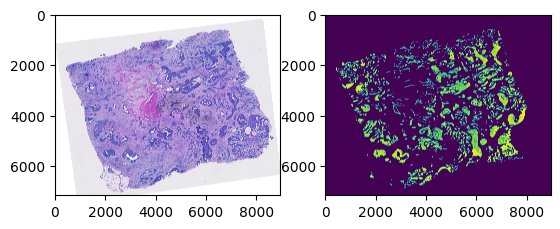

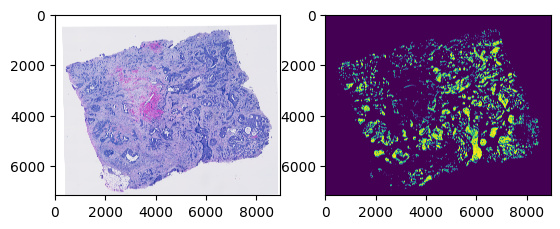

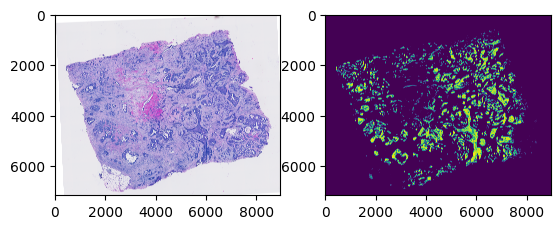

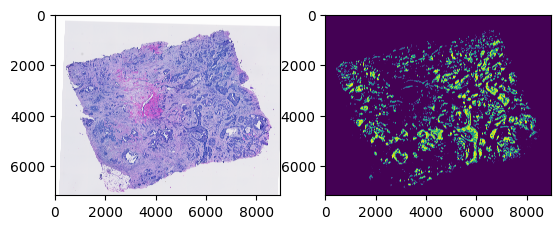

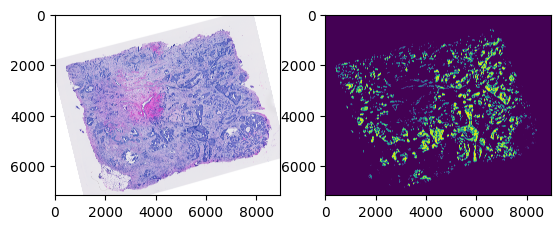

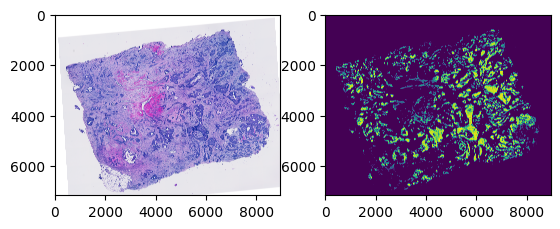

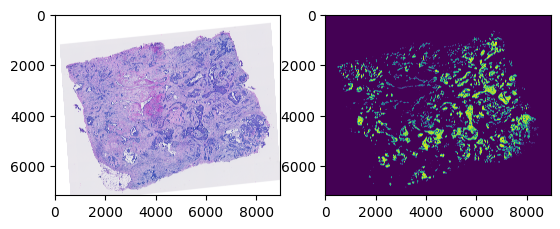

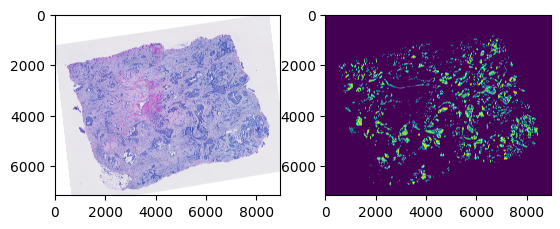

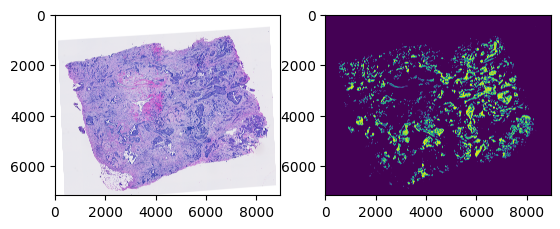

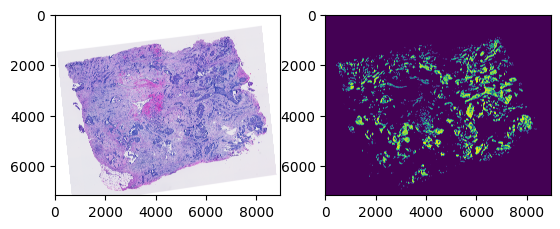

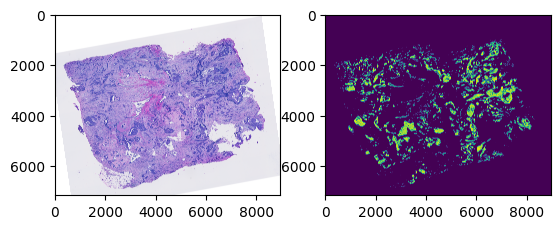

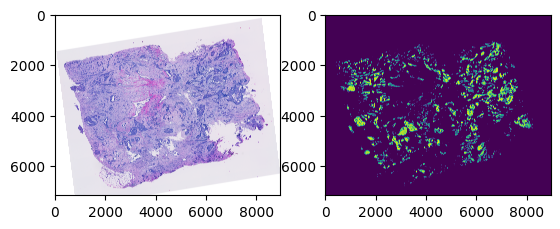

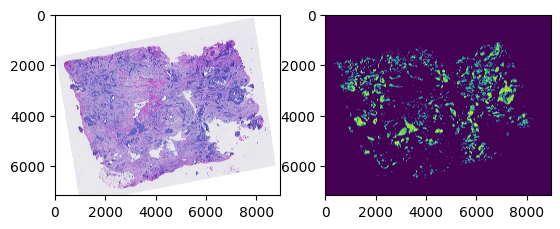

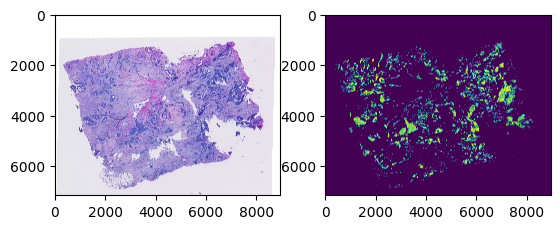

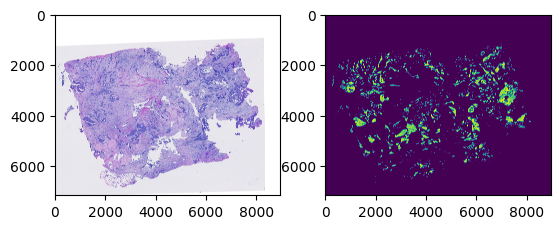

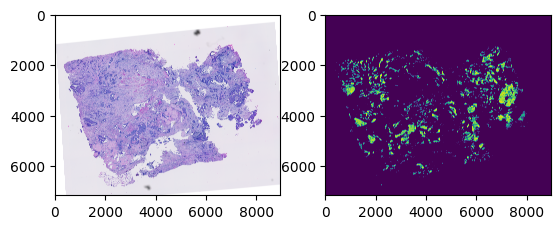

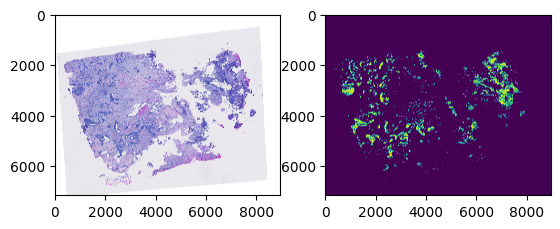

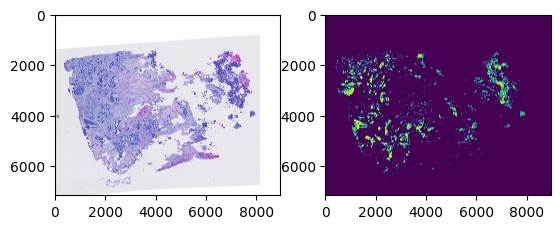

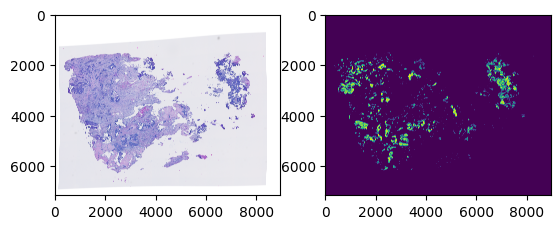

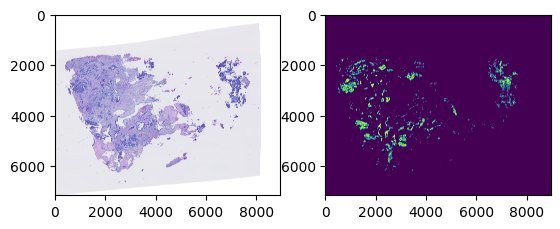

In [99]:
for tiled_pred, tiled_he in zip(tiled_preds, tiled_hes):
    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(to_he(tiled_he, norm=norm))
    ax[1].imshow(tiled_pred)
    plt.show()

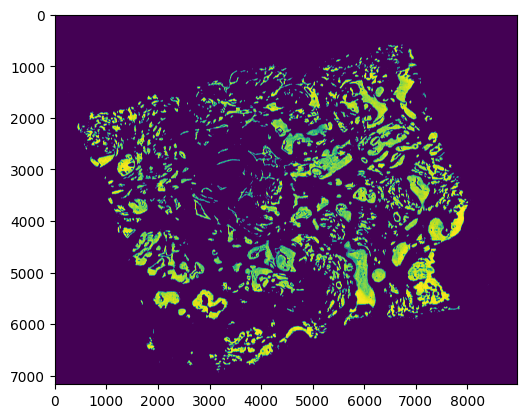

In [71]:
plt.imshow(tiled_pred)

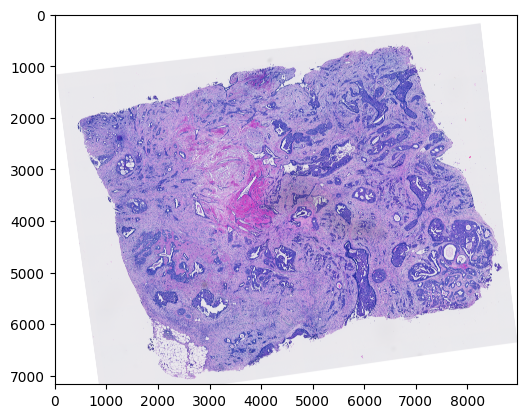

In [72]:
plt.imshow(to_he(tiled_he, norm=norm))

In [32]:
outputs = trainer.predict(model, val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                       | 0/? [00:…

In [33]:
outputs[0].keys()

dict_keys(['loss', 'outputs'])

In [35]:
outputs[0]['outputs'].shape

torch.Size([64, 1, 256, 256])

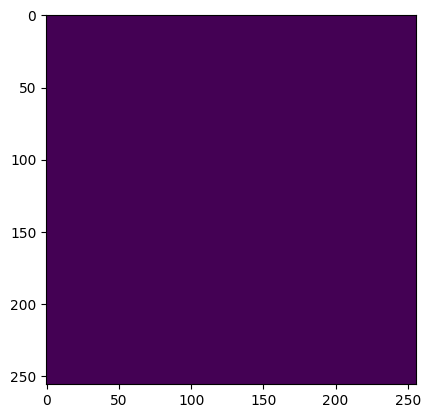

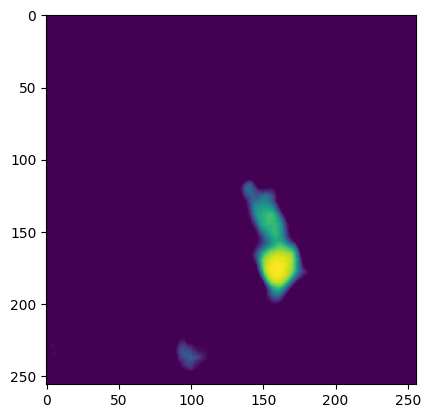

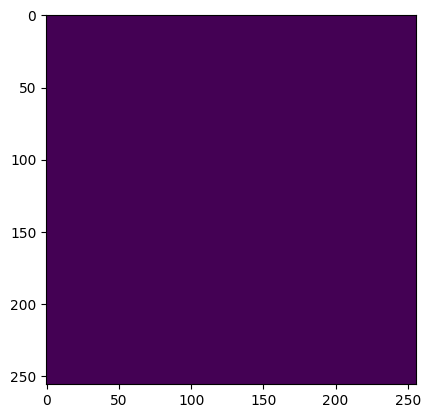

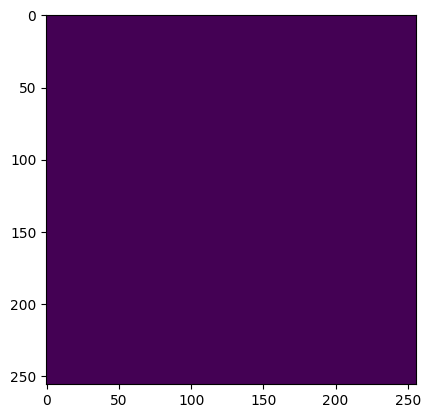

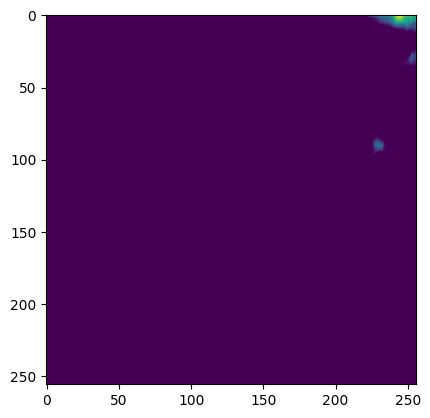

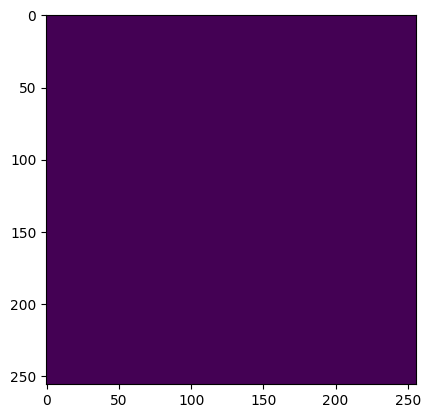

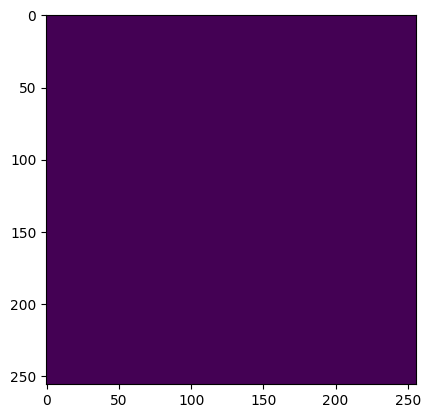

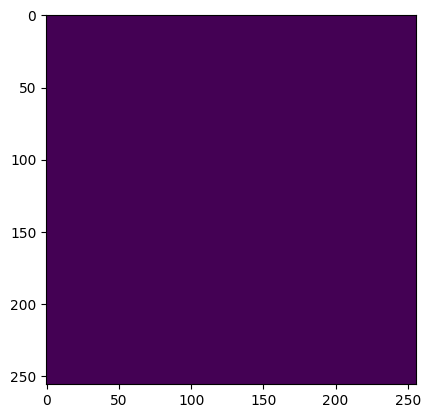

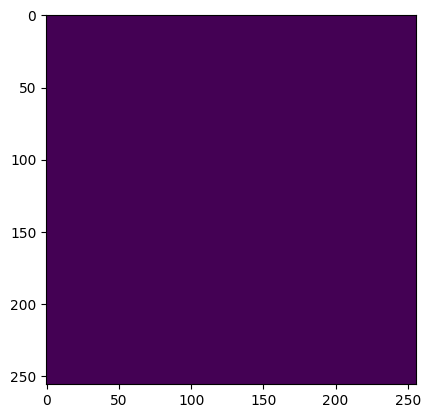

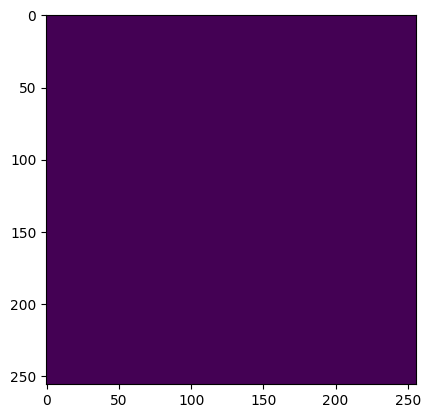

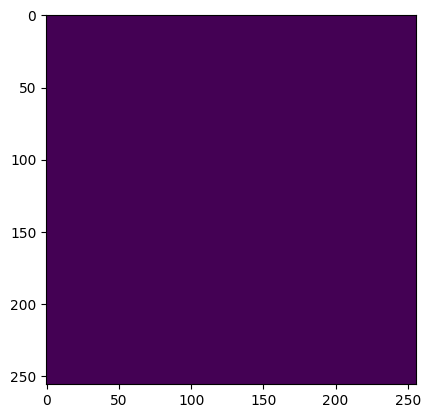

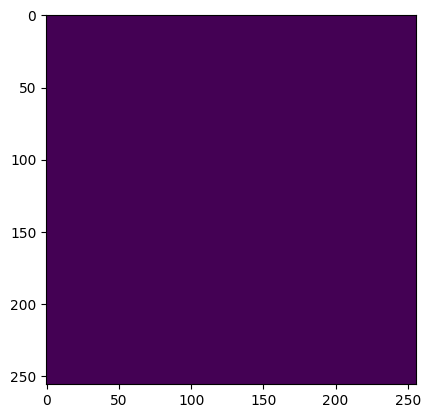

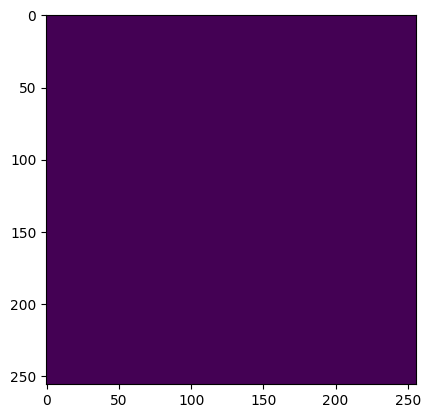

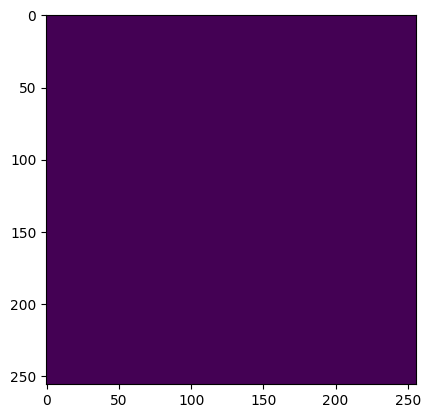

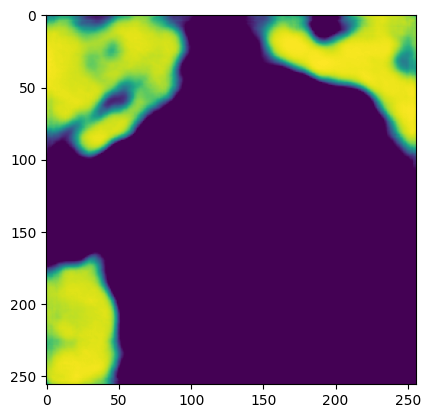

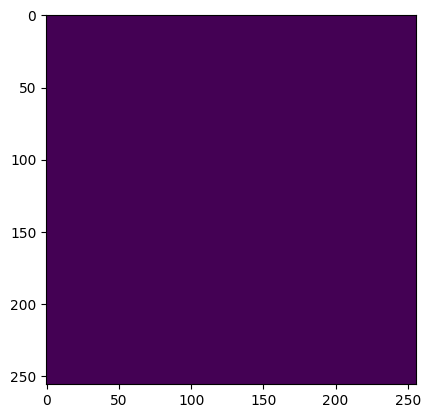

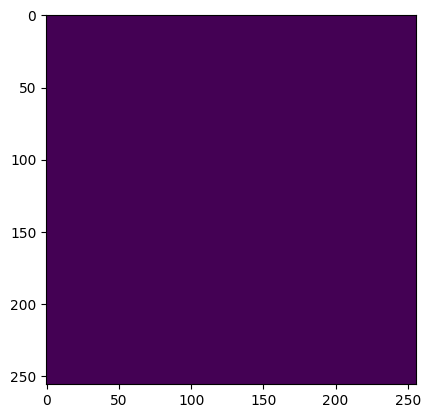

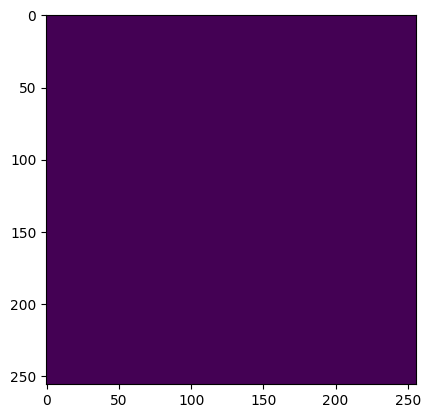

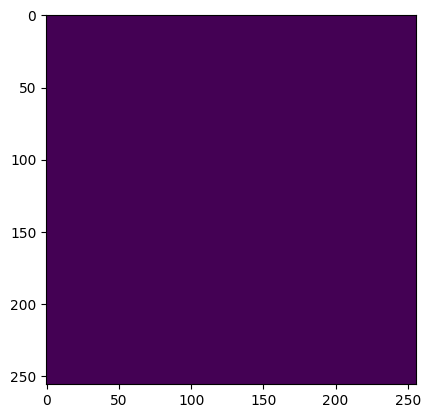

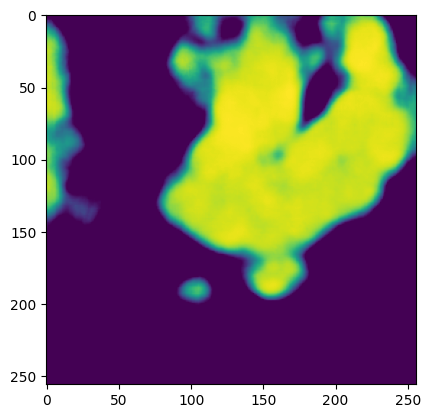

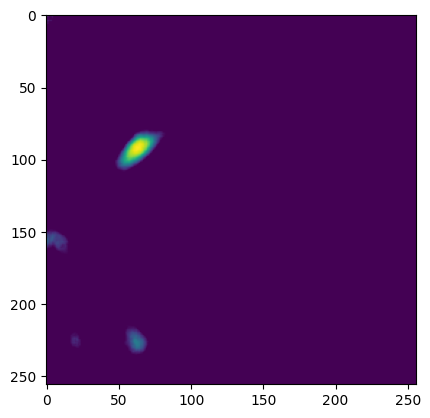

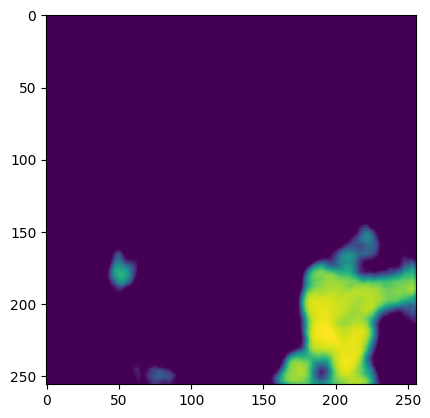

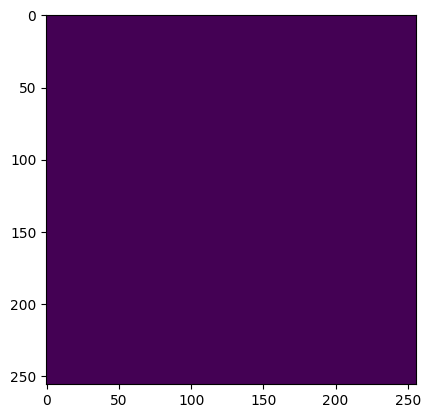

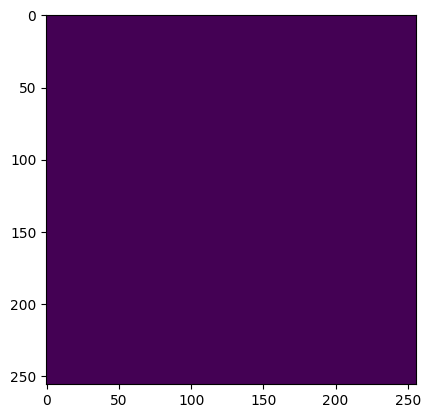

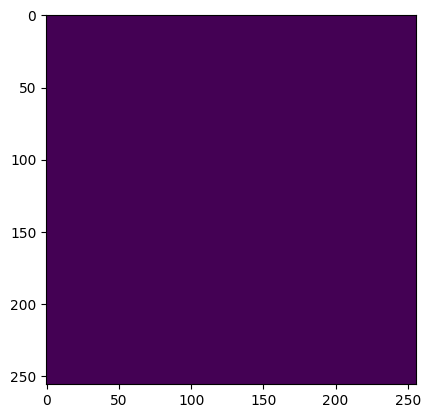

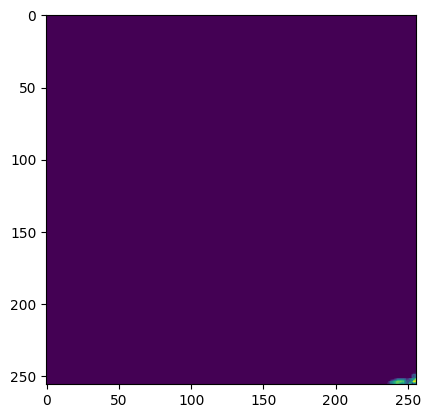

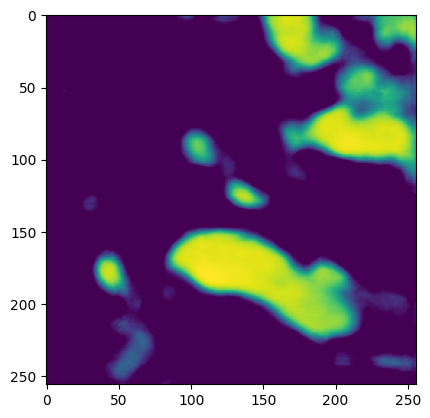

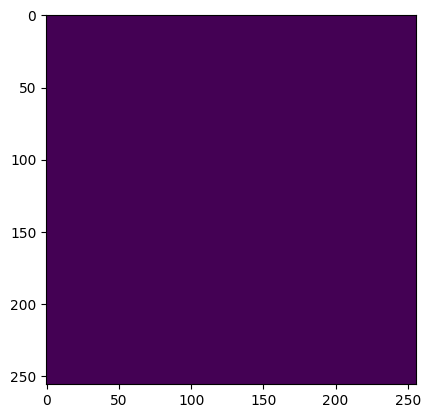

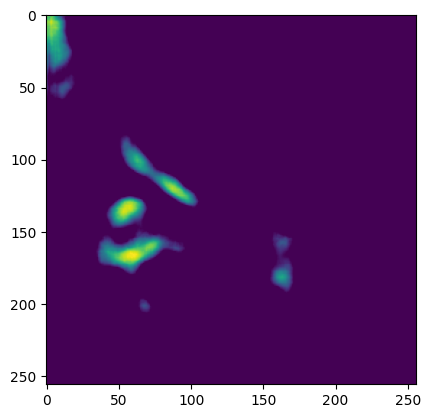

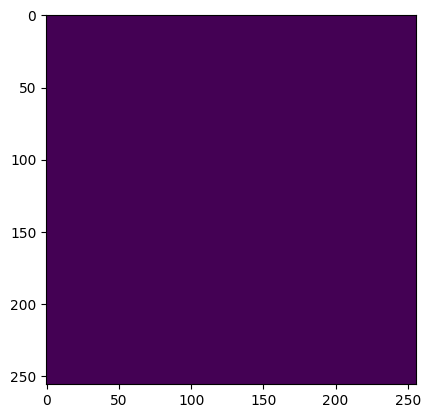

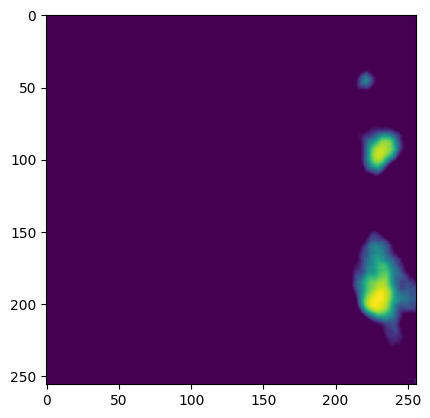

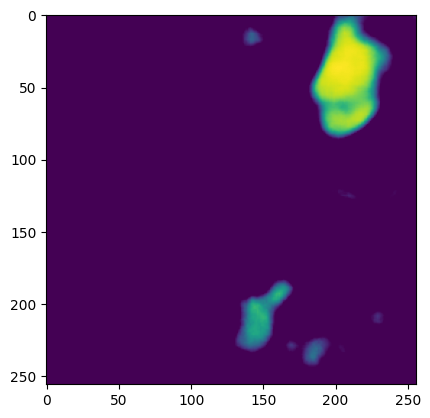

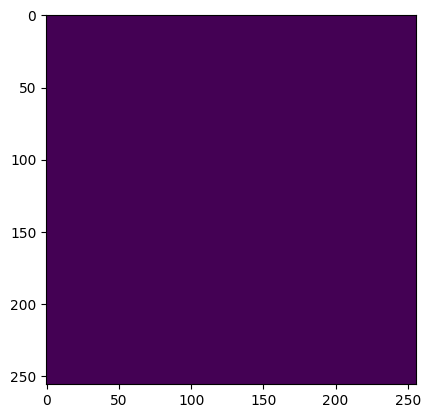

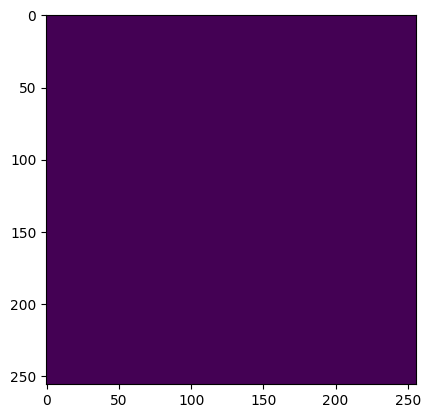

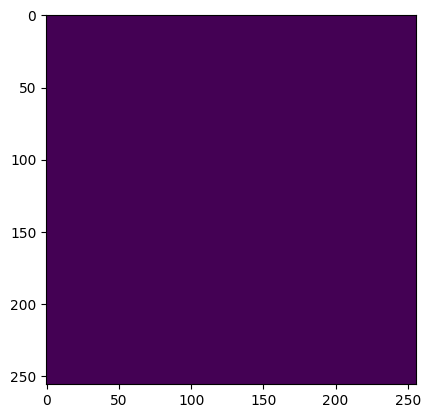

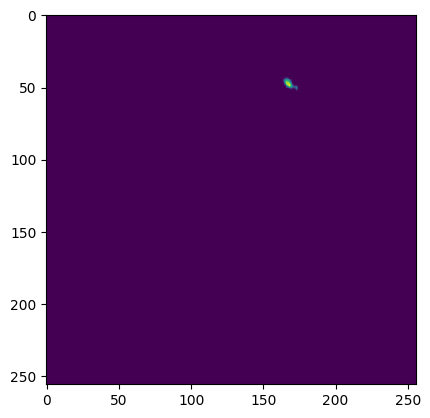

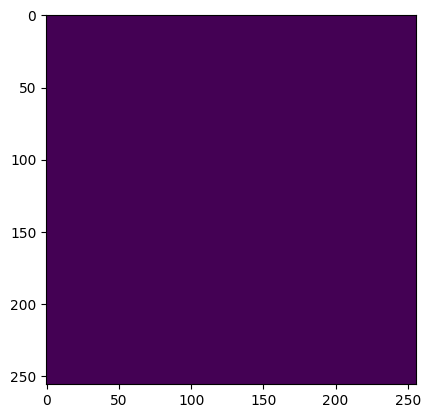

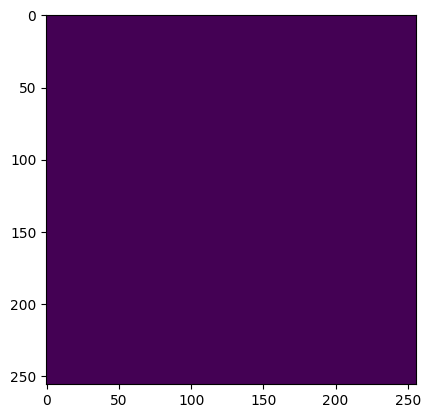

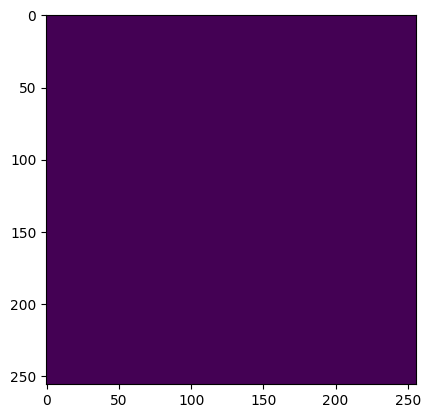

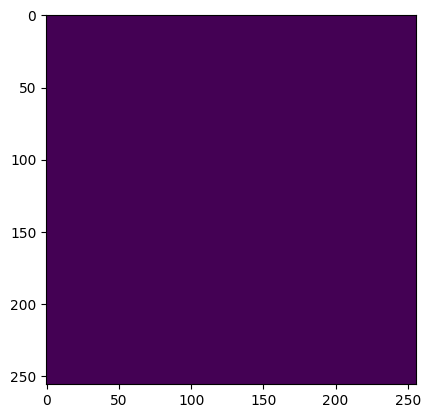

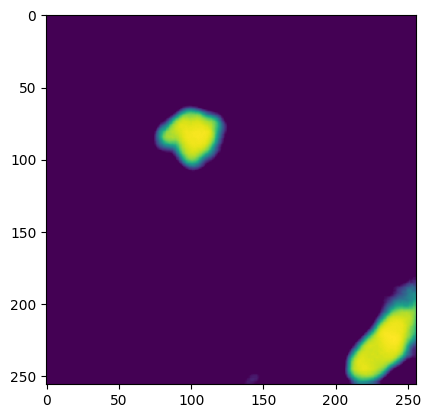

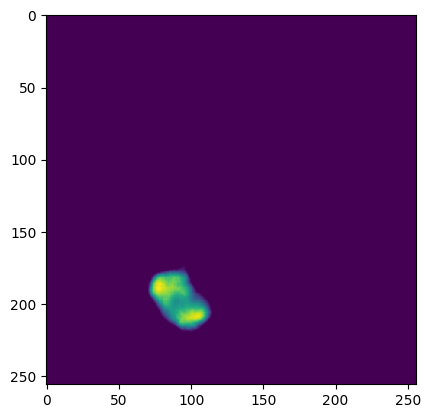

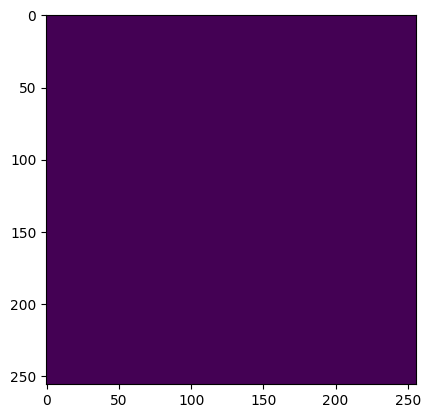

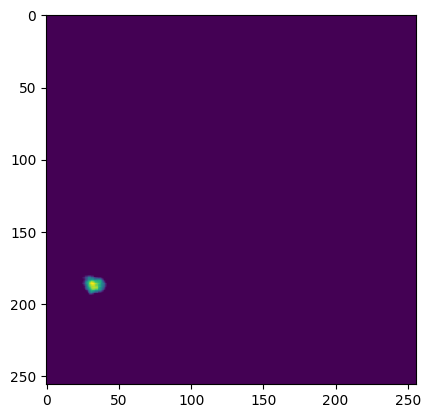

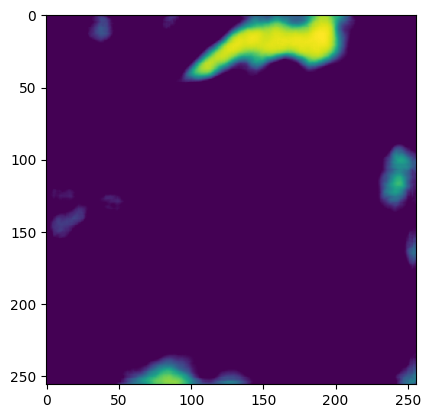

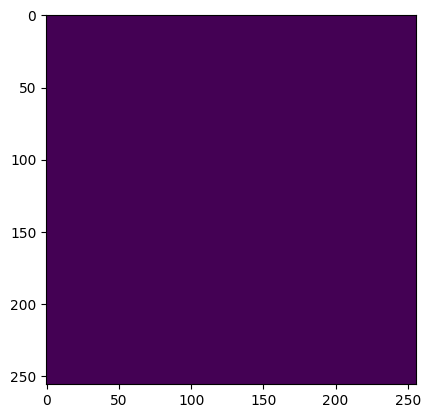

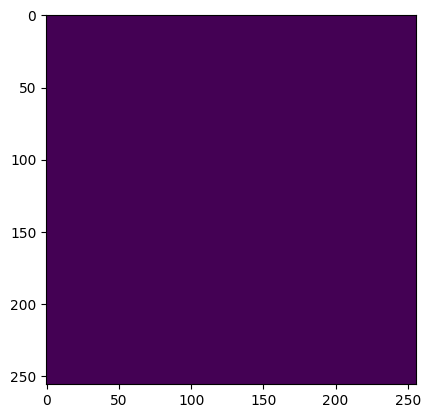

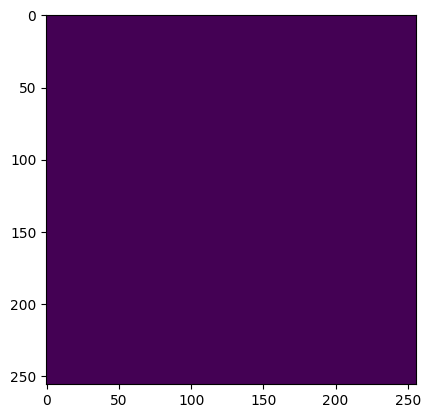

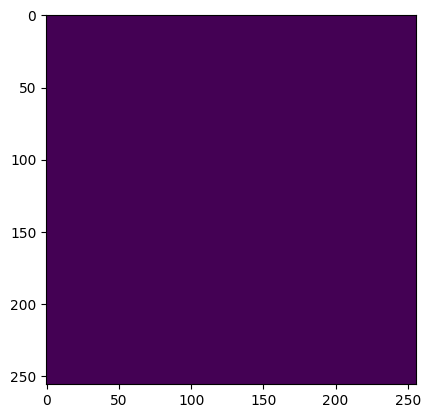

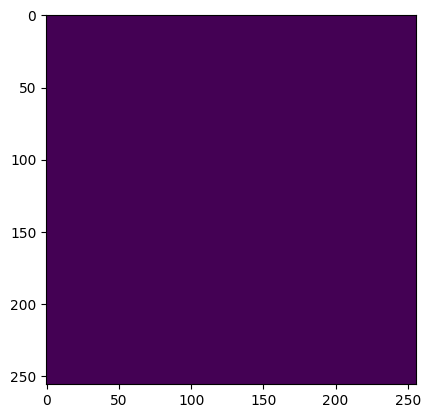

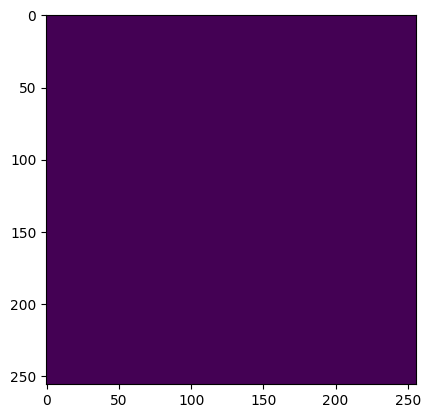

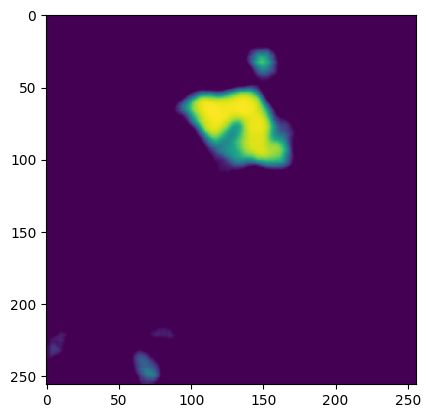

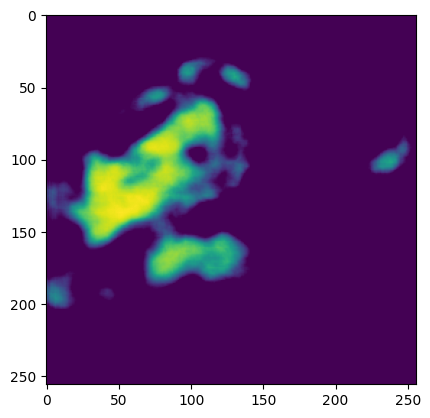

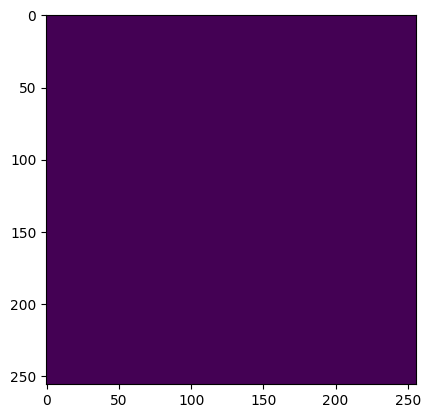

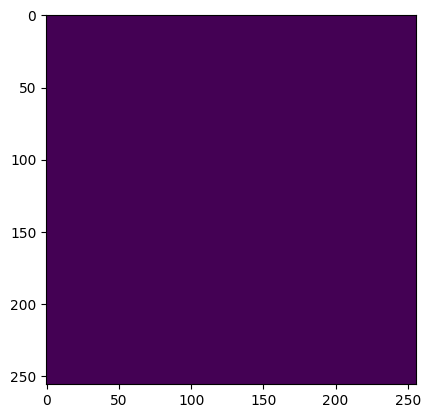

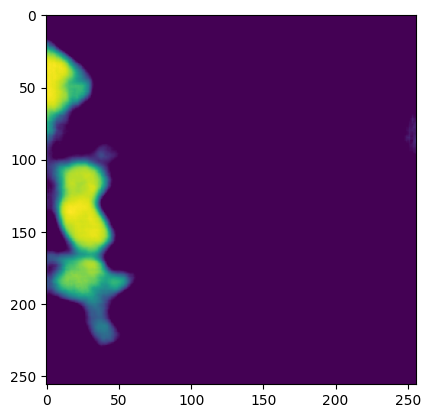

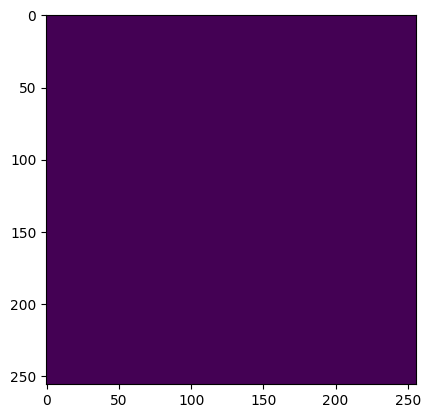

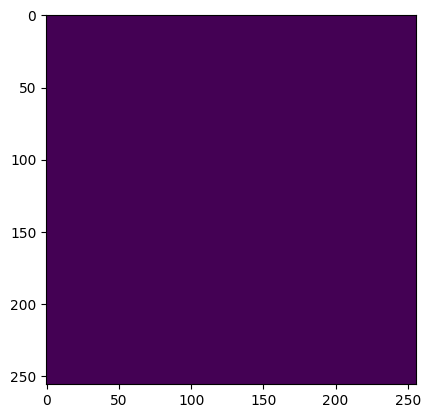

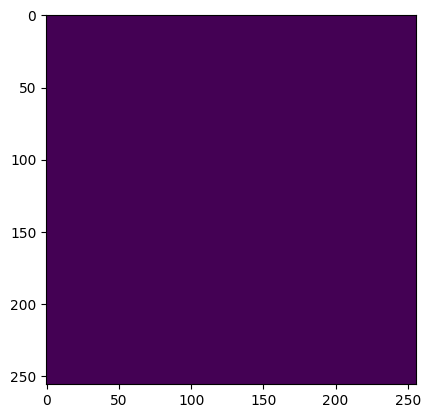

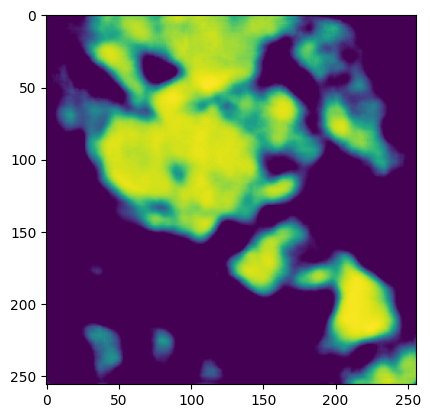

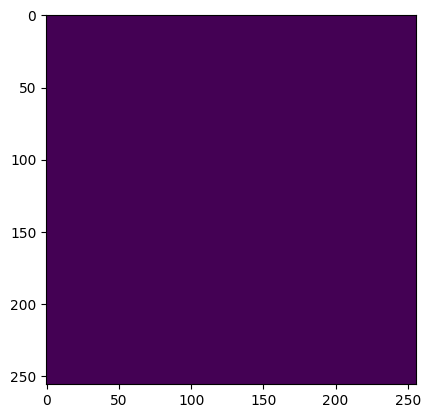

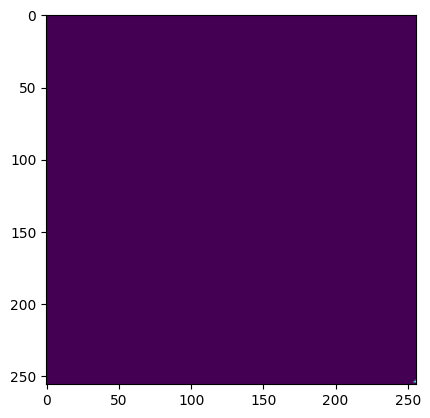

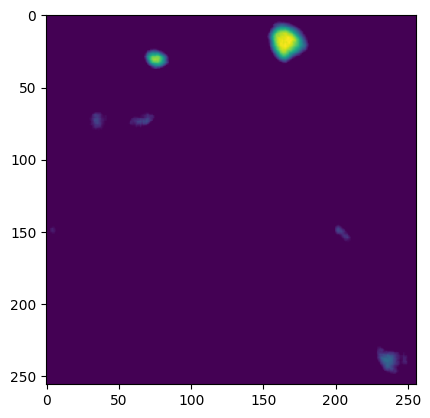

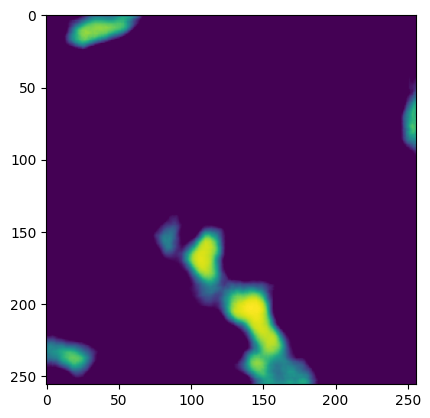

In [37]:
for x in outputs[0]['outputs']:
    plt.imshow(x[0])
    plt.show()

In [246]:
item['he'][0].shape

torch.Size([3, 256, 256])

In [249]:
b = rearrange(item['he'][0], 'c h w -> 1 c h w')
x = unet(b)
x.shape

torch.Size([1, 1, 256, 256])

In [248]:
encoder = create_model(
            'resnet18', features_only=True, out_indices=None, in_chans=3,
            pretrained=True)

In [ ]:
x = encoder()